In [1]:
%matplotlib widget
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
from scipy.signal import find_peaks
sys.path.append("/pymorph")
from schemes.weno import get_left_flux,get_right_flux, get_Max_Phase_Speed
from schemes.weno import get_stencil

import morph_geom_lib as mgl
import models.simple_depth_morph_models as sdmodels
import schemes.avalanche_scheme 


from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')

%load_ext autoreload
%autoreload 2
%matplotlib inline

dx: 0.9762202753441801 cm
nx 800


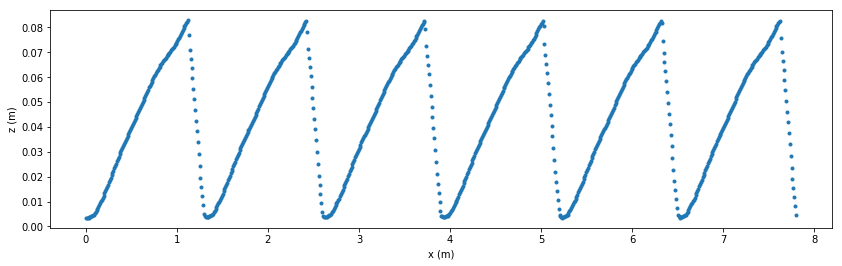

In [3]:
filepath = '../Paper_3/dune_profile_dune5_repeated.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


def readFile(filepath, resolution_cells = 800):
    xs = []
    zs = []
    with open(filepath) as f:
        for line in f:
            values = line.split(',')
            if is_number(values[0]) and is_number(values[1]):
                x = float(values[0])
                z = float(values[1])
                xs.append(x)
                zs.append(z)
                
    xs = np.array(xs)
    zs = np.array(zs)
    
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    xmax = xs.max()
    nx = len(xs)
    f = interp1d(xs, zs)
    
    xnew = np.linspace(0., xmax, num=resolution_cells)
    znew = f(xnew)
    return xnew, znew

x0,z0 = readFile(filepath, resolution_cells = 800)



dx = x0[1] - x0[0]

'''z0slope = z0.copy()
dx = x0[1] - x0[0]
for i in range(len(z0)):
    z0[i] = z0[i] - dx*( 1.26/1000. )'''

'''x0 = x0[40:]
z0 = z0[40:]'''

print('dx: {0} cm'.format(dx*100.))
print('nx {0}'.format(len(x0)))

fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0, '.')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

sOut32 = 0.357
sOut20 = 0.237



In [4]:
def get_peaks(z):
        top_peaks, _ = find_peaks(z, height = z.mean()*1.1, distance = int(1.0/dx))
        
        bottom_peaks, _ = find_peaks(-1.*z, height = z.mean()*-0.8, distance = int(1.0/dx))

        #print(top_peaks, bottom_peaks)
        return top_peaks, bottom_peaks
    
def calculate_bedload_norm(zloc, qin, surface):    
    a = 0.001
    b = 3
    u = qin/(surface-zloc)
    qbedload =  (a * u**b)

    return qbedload

def calculate_bedload(zloc, qin, surface, zr):    
    a = 0.001
    b = 3
    u = qin/(surface-zloc)
    ur = qin/(surface-zr)
    qbedload = (a *(u-ur) **b)*20.

    return qbedload

def calculate_bedload_profile(x, z, q20cm, sOut20):
    
        
    top_peaks, bottom_peaks = get_peaks(z)
    xcrests = [x[i] for i in top_peaks]
    zcrests = [z[i] for i in top_peaks]
    

    xbottom = [x[i] for i in bottom_peaks]
    zbottom = [z[i] for i in bottom_peaks]

    z_reattachment = []

    for i in range(len(bottom_peaks)-1):

        if top_peaks[i] > bottom_peaks[i]:
            # At the top
            height = zcrests[i] - zbottom[i]
            xreattachment = (5.* height) + xcrests[i]
            #print(xreattachment)

            index = bottom_peaks[i]
            while index < len(x) and x[index] < xreattachment:
                index += 1

            z_reattachment.append(z[index]) 
            

        else:
            # At the bottom
            height = zcrests[i] - zbottom[i]
            xreattachment = (5.* height) + xcrests[i]

            index = bottom_peaks[i]
            while index < len(x) and x[index] < xreattachment:
                index += 1

            z_reattachment.append(z[index]) 
    
    z_reattachment = np.array(z_reattachment)
    
    qbedload = [calculate_bedload_norm(z[i],q20cm,sOut20) for i in range(len(z))]    
    
    qbedloadReattach = calculate_bedload_norm(z_reattachment.mean(),q20cm,sOut20) 
    
    qbedload = (qbedload - qbedloadReattach)
    
    return qbedload
        

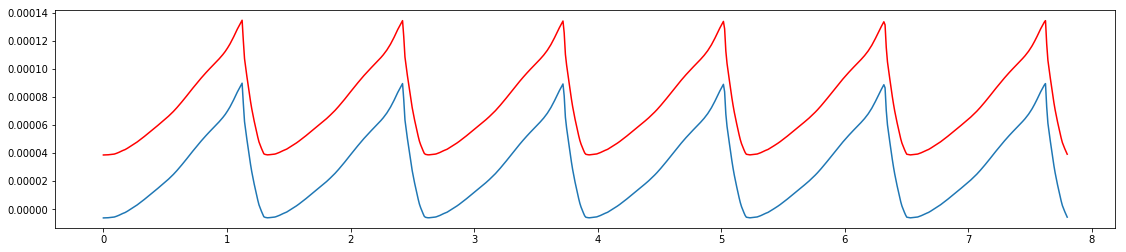

In [5]:
qbedload = calculate_bedload_profile(x0,z0, q20cm,sOut20)

top_peaks, bottom_peaks = get_peaks(z0)

fig = plt.figure(figsize=(19, 4))

xstop = [x0[i] for i in top_peaks]
zstop = [z0[i] for i in top_peaks]

xsbottom = [x0[i] for i in bottom_peaks]
zsbottom = [z0[i] for i in bottom_peaks]

#plt.plot(xstop, zstop, 'r*')
#plt.plot(xsbottom, zsbottom, 'r*')

qbedload2 = [calculate_bedload_norm(z0[i],q20cm,sOut20 ) for i in range(len(z0))]    



plt.plot(x0, qbedload)
plt.plot(x0, qbedload2, 'r')
#plt.plot(x0,z0)


In [6]:
def calculate_wave_height( z):
    top_peaks, _ = find_peaks(z, height = z.mean()*1.1)
    bottom_peaks, _ = find_peaks(-1.*z, height = z.mean()*-0.8, distance = int(1.2/dx))

    ztop = [z[i] for i in top_peaks]
    zbottom = [z[i] for i in bottom_peaks]

    ztop = np.array(ztop)
    ztop = np.delete(ztop, ztop.argmin())
    
    zbottom = np.array(zbottom)
    zbottom = np.delete(zbottom, zbottom.argmax())
    

    return ztop.mean() - zbottom.mean()
                
            
    
def calculate_wave_length(z,dx):
    peaks, _ = find_peaks(-1.*z, height = z.mean()*-1., distance = int(1.2/dx))
    lengths = []
    last_peak = None
    for peak in peaks:
        if last_peak == None:
            last_peak = peak
        else:
            
            tmpLength = dx * (peak-last_peak)
            
            if tmpLength > 1.2:
                lengths.append(tmpLength)
                last_peak = peak
                
    lengths = np.array(lengths)
    #lengths = np.delete(lengths, lengths.argmin())
    return lengths
    
def calculate_wave_movement(last_peak_index, current_z):
    
    peaks, _ = find_peaks(-1.*current_z, height = current_z.mean()*-0.8, distance = int(1.2/dx))
    
    updated_peak = None
    for peak in peaks:
        if peak > last_peak_index:
            updated_peak = peak
            #print(peak, last_peak_index)
            break

    return updated_peak

def calculate_wave_speed(verts, dx, dt):
    last_peak_index = None
    velocities = []
    timesteps = []
    base_index = 2
    step_index = 4
    for t in range(0, (verts.shape[0]), step_index):
        current_z = verts[t,:,1]
        peaks, _  = find_peaks(-1.*current_z, height = -1*current_z.mean(), distance=100)
        if last_peak_index is not None:
            delta = calculate_wave_movement(last_peak_index, current_z)
            last_peak_index = peaks[base_index]
            velocities.append(delta*dx/(dt*step_index))
            timesteps.append( dt * t )
        last_peak_index = peaks[base_index]
    return velocities, timesteps

def plot_results(verts):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))

    heights = [calculate_wave_height(verts[t,:,1]) for t in range((verts.shape[0]))]
    times = [t*5. for t in range((verts.shape[0]))]

    ax1.plot(times, heights)
    ax1.set_xlabel('Time (mins)')
    ax1.set_ylabel('$\Delta$ (m)')

    dx = x[1] - x [0]
    lengths = [calculate_wave_length(verts[t,:,1],dx).mean() for t in range((verts.shape[0]))]
    ax2.plot(times, lengths)
    ax2.set_xlabel('Time (mins)')
    ax2.set_ylabel('$\Lambda$ (m)')
    ax2.set_ylim([0, 3.0])

    for t in range(0, (verts.shape[0]),15):
        z = verts[t,:,1]
        h = verts[t,:,4]
        x = verts[t,:,0]
        timestep = t * 5.
        ax3.plot(x,z, label='{0} mins'.format(timestep))
        ax3.plot(x,z+h, 'b')

    ax3.legend()
    ax3.set_xlabel('x (m)')
    ax3.set_ylabel('z (m)')


    v, timesteps = calculate_wave_speed(verts, dx, 5)
    ax4.plot(timesteps,v)
    ax4.set_ylim([0, 0.5])

    ax4.set_xlabel('Time (mins)')
    ax4.set_ylabel('Dune migration rate (m/min)')

    f.subplots_adjust(hspace=0.3)
    
def make_animation(verts):
    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure(figsize=(12, 3))
    ax = plt.axes(xlim=(0, 8), ylim=(0, 0.1))

    x0 = verts[0,:,0]
    z0 = verts[0,:,1]

    plt.plot(x0,z0)
    line, = ax.plot([], [], lw=2)



    # initialization function: plot the background of each frame
    def init():
        line.set_data([], [])
        return line,

    # animation function.  This is called sequentially
    def animate(i):
        x = verts[i,:,0]
        y = verts[i,:,1]
        line.set_data(x, y)
        return line,
    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=58, interval=80, blit=True)
    return anim

396.88336039998103


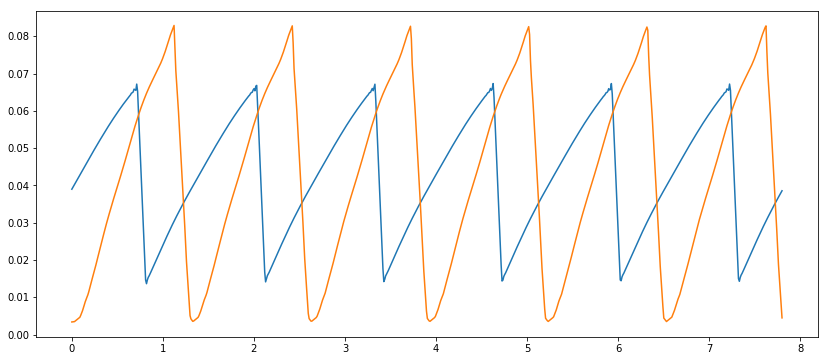

In [7]:
xc = x0.copy()
zc = z0.copy()


nP=0.4
Slope = 1.26/1000 # Based on table 4.1 in Wiebe
mannings = 0.0248
beta = 0.01

D50 = 0.001

nx = len(xc)
# 32 cm Case 
Qc132 = 0.045
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

#sws.set_boundary_conditions()
surf = 0.357
Qin = q32cm


q20cm,sOut20


#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 60*5 # Runtime in seconds
dt = 1 # Time step size (s)
extractionInterval = 60.*1
nt = int(simTime/dt)  # Number of time st

qbedload = np.zeros(len(xc))
cntr = 0

qin = q32cm
surf = 0.357

time_series = collections.OrderedDict()
time = 0

from timeit import default_timer as timer
start = timer()
verts = []
#--------------------------------
#  Run the model
#--------------------------------
for n in range(1,nt):  
    zn = zc.copy() 
    z1 = zc.copy() 
    roe_speed =0
    flux = np.zeros(nx)
    # Need the sign of the phase speed
    # Need to check this out
    for i in range(0,nx): #i=2       
        zloc = get_stencil(zn,i-2,i+4)
        #print xloc
        #raise ValueError()
        
        # Since k=3
        # stencil is i-2 to i+2 
        qloc = get_stencil(qbedload,i-2,i+4)
        if len(qloc) != 6:
            raise ValueError('Stencil is incorrect')
        
        if (zloc[3]-zloc[2]) == 0.0:
            roe_speed=np.sign( (qloc[3]-qloc[2]) )
        else:
            roe_speed=np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )                

        if roe_speed >= 0.0:
            flux[i] = get_left_flux(qloc)
        else:
            print('right')
            flux[i] = get_right_flux(qloc)
        
    # Need the sign of the phase speed
    # Need to check this out

    for i in range(0,nx): #i=2       
        floc = get_stencil(flux,i-1,i+1)
        # This is essentially eq. 8. 
        z1[i] = zn[i]-(1./(1.-nP))*(dt/(1.0*dx))*(floc[1]-floc[0])
        
    qbedload1 = calculate_bedload_profile(x0,z1,qin,surf)
    
    ##-------------Step 2 -------------
    for i in range(0,nx): #i=2       
        zloc = get_stencil(z1,i-2,i+4)
        #print xloc
        #raise ValueError()
        
        # Since k=3
        # stencil is i-2 to i+2 
        qloc = get_stencil(qbedload1,i-2,i+4)
        if len(qloc) != 6:
            raise ValueError('Stencil is incorrect')
        
        if (zloc[3]-zloc[2]) == 0.0:
            roe_speed = np.sign( (qloc[3]-qloc[2]) )
        else:
            roe_speed =np.sign( (qloc[3]-qloc[2])/ (zloc[3]-zloc[2]) )
        
        if roe_speed >= 0.0:
            flux[i] = get_left_flux(qloc)
        else:
            flux[i] = get_right_flux(qloc)
        
    # Need the sign of the phase speed
    # Need to check this out

    for i in range(0,nx): #i=2       
        floc = get_stencil(flux,i-1,i+1)
        # This is essentially eq. 8. 
        zc[i] = 0.5*zn[i] + 0.5*z1[i] - 0.5*(1./(1.-nP))*(dt/(1.0*dx))*(floc[1]-floc[0])
    
    bed_max_delta = np.max(np.abs(zn - zc))
    
    # Apply the avalanche model
    zc, iterations1 = avalanche_model(dx,xc, zc, adjustment_angle=28.)
    # Now flip it to run in reverse
    zflip = np.flip(zc, axis=0)
    zflip, iterations1 = avalanche_model(dx,xc, zflip, adjustment_angle=28.)
    zc = np.flip(zflip, axis=0)
    
    qbedload = calculate_bedload_profile(x0,zc, qin,surf)
        
    time_series[time] = zc
    time+=1
    
    verts.append(list(zip(xc.copy(),zc.copy(), qbedload.copy())))
        
        
end = timer()
print(end - start) # Time in seconds, e.g. 5.38091952400282

fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
#Co = get_Max_Phase_Speed(qbedload,zc,nP)*dt/dx

#print('Courant Number: {0}'.format(Co))



plt.plot(x0,z0)

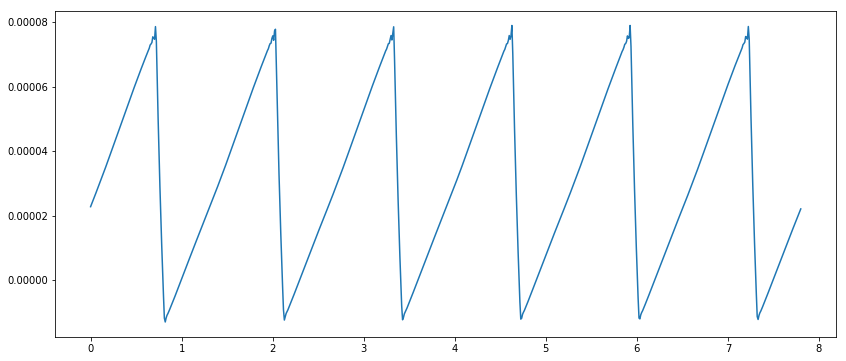

In [8]:
fig = plt.figure(figsize=(14, 6))
qbedload3 = calculate_bedload_profile(xc,zc, qin,surf)

plt.plot(xc, qbedload3)

2019-05-18 00:01:53,140 INFO CLAW: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2019-05-18 00:01:53,141 INFO CLAW: MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '864x216', '-pix_fmt', 'rgba', '-r', '76.92307692307692', '-loglevel', 'quiet', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpj61uw_70/temp.m4v']


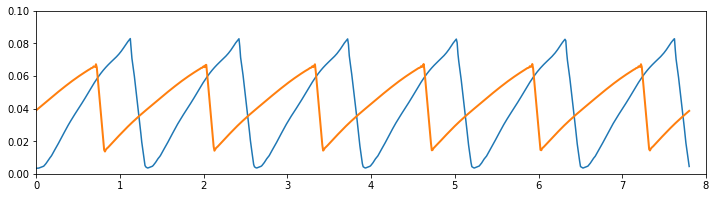

In [307]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(12, 3))
ax = plt.axes(xlim=(0, 8), ylim=(0, 0.1))
plt.plot(x0,z0)
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = xc
    y = time_series[i]
    line.set_data(x, y)
    return line,
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=time, interval=13, blit=True)
HTML(anim.to_html5_video())

In [297]:
xc = x0.copy()
zc = z0.copy()


nP=0.4
Slope = 1.26/1000 # Based on table 4.1 in Wiebe
mannings = 0.0248
beta = 0.01

D50 = 0.001

nx = len(xc)
# 32 cm Case 
Qc132 = 0.045
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

#sws.set_boundary_conditions()
surf = 0.237
Qin = q20cm

#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 60*5 # Runtime in seconds
dt = 10 # Time step size (s)
extractionInterval = 60.*1
nt = int(simTime/dt)  # Number of time st

qbedload = np.zeros(len(xc))
cntr = 0

time_series = collections.OrderedDict()
time = 0

from timeit import default_timer as timer
start = timer()

#--------------------------------
#  Run the model
#--------------------------------
for n in range(1,nt):  
    zn = zc.copy() 
    zhatn = zc.copy() 
    alpha = np.zeros(nx)
        
    # Need the sign of the phase speed
    # Need to check this out
      
    for i in range(0,nx): #i=2       
        qloc = get_stencil(qbedload,i-1,i+2)  
        zhatn[i] = zn[i]-(1./(1.-nP))*dt/(dx)*(qloc[1] - qloc[0])
        
    qbedload = calculate_bedload_profile(x0,zhatn)
        
    for i in range(0,nx): #i=2       
        qloc = get_stencil(qbedload,i-1,i+2)  
        zc[i] = 0.5*(zhatn[i]+zn[i]) - (1/(1.-nP))*dt/(dx*2.)*(qloc[2] - qloc[1])
        
    
    # Apply the avalanche model
    zc, iterations1 = avalanche_model(dx,xc, zc, adjustment_angle=28.)
    # Now flip it to run in reverse
    zflip = np.flip(zc, axis=0)
    zflip, iterations1 = avalanche_model(dx,xc, zflip, adjustment_angle=28.)
    zc = np.flip(zflip, axis=0)
    
    qbedload = calculate_bedload_profile(x0,zc)
        
    time_series[time] = zc
    time+=1
        
        
end = timer()
print(end - start) # Time in seconds, e.g. 5.38091952400282

fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
#Co = get_Max_Phase_Speed(qbedload,zc,nP)*dt/dx

#print('Courant Number: {0}'.format(Co))



plt.plot(x0,z0)

KeyboardInterrupt: 

In [ ]:
qsb  = calculate_bedload_profile(x0,zc)
plt.plot(x0, qsb)

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(12, 3))
ax = plt.axes(xlim=(0, 8), ylim=(0, 0.1))
plt.plot(x0,z0)
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = xc
    y = time_series[i]
    line.set_data(x, y)
    return line,
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=time, interval=15, blit=True)
HTML(anim.to_html5_video())

In [9]:



'''def calculate_bedload_profile(x, z):
    
    qbedload = [calculate_bedload(z[i],q20cm,sOut20 ) for i in range(len(z))]
    qbedload = np.array(qbedload)
    
    top_peaks, bottom_peaks = get_peaks(z)
    xcrests = [x[i] for i in top_peaks]
    zcrests = [z[i] for i in top_peaks]
    qcrests = [calculate_bedload(z[i],q20cm,sOut20 ) for i in top_peaks]

    xbottom = [x[i] for i in bottom_peaks]
    zbottom = [z[i] for i in bottom_peaks]

    reattachment_index = []

    for i in range(len(bottom_peaks)):

        if top_peaks[i] > bottom_peaks[i]:
            # At the top
            height = zcrests[i] - zbottom[i]
            xreattachment = (5.* height) + xcrests[i]
            #print(xreattachment)

            index = bottom_peaks[i]
            while index < len(x) and x[index] < xreattachment:
                index += 1

            reattachment_index.append([index]) 
            
            qbedload[top_peaks[i]:index] = 0.
            
            if i < len(bottom_peaks)-1:
                xbottom = x[bottom_peaks[i+1]]
                
                for j in range(bottom_peaks[i+1], index):
                    qbedload[j] =-0.01*(np.sin(math.pi*(x[j] - xbottom )/(xreattachment-xbottom)))/700
                
                for j in range(index, top_peaks[i+1]):
                    qbedload[j] = qbedload[j]*(x[j] -xreattachment )/(xcrests[i+1] - xreattachment)

        else:
            # At the bottom
            height = zcrests[i] - zbottom[i]
            xreattachment = (5.* height) + xcrests[i]
            print(xreattachment)

            index = bottom_peaks[i]
            while index < len(x) and x[index] < xreattachment:
                index += 1

            reattachment_index.append([index]) 
            
            #qbedload[top_peaks[i]:index] = 0.
            
            #if i < len(bottom_peaks)-1:
            #print(top_peaks[i], bottom_peaks[i], index)
            xbottom = x[bottom_peaks[i]]

            for j in range(bottom_peaks[i], index):
                qbedload[j] =-0.01*(np.sin(math.pi*(x[j] - xbottom )/(xreattachment-xbottom)))/700
                #qbedload[j] =-0.01*(np.sin(0.5*math.pi*(xbottom + x[j] )/(xreattachment-xbottom)))/700
                
            for j in range(index, top_peaks[i+1]):
                qbedload[j] = qbedload[j]*(x[j] -xreattachment )/(xcrests[i+1] - xreattachment)           
    
    
    return qbedload'''

'def calculate_bedload_profile(x, z):\n    \n    qbedload = [calculate_bedload(z[i],q20cm,sOut20 ) for i in range(len(z))]\n    qbedload = np.array(qbedload)\n    \n    top_peaks, bottom_peaks = get_peaks(z)\n    xcrests = [x[i] for i in top_peaks]\n    zcrests = [z[i] for i in top_peaks]\n    qcrests = [calculate_bedload(z[i],q20cm,sOut20 ) for i in top_peaks]\n\n    xbottom = [x[i] for i in bottom_peaks]\n    zbottom = [z[i] for i in bottom_peaks]\n\n    reattachment_index = []\n\n    for i in range(len(bottom_peaks)):\n\n        if top_peaks[i] > bottom_peaks[i]:\n            # At the top\n            height = zcrests[i] - zbottom[i]\n            xreattachment = (5.* height) + xcrests[i]\n            #print(xreattachment)\n\n            index = bottom_peaks[i]\n            while index < len(x) and x[index] < xreattachment:\n                index += 1\n\n            reattachment_index.append([index]) \n            \n            qbedload[top_peaks[i]:index] = 0.\n            \n       

In [10]:
q20cm

0.07894736842105263